<a href="https://colab.research.google.com/github/Rushabh2499/CodersWeek-ML/blob/master/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

We studied the fundamental ideas of machine learning, but all of the examples assume that you have numerical data in a tidy, ``[n_samples, n_features]`` format.
In the real world, data rarely comes in such a form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this section, we will cover a few common examples of feature engineering tasks: features for representing *categorical data*, features for representing *text*, and features for representing *images*.
Additionally, we will discuss *derived features* for increasing model complexity and *imputation* of missing data.
Often this process is known as *vectorization*, as it involves converting arbitrary data into well-behaved vectors.

#Label Enoder


In [0]:
import pandas as pd

cities=pd.Series(['Delhi', 'Kolkata', 'Pune','Mumbai'])

In [0]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in list 'cities'. 
transformed= label_encoder.fit_transform(cities)
transformed

array([0, 1, 3, 2])

In [0]:
#lets do this for a dataframe

import pandas as pd
city_names = pd.Series(['Mumbai', 'Delhi','Banglore'])
population = pd.Series([852469, 1015785, 485199])

cities=pd.DataFrame({ 'City name': city_names, 'Population': population })

#Define Label Encoder
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'City'. 
cities["New City Code"]= label_encoder.fit_transform(cities["City name"])

In [0]:
cities

,City name,Population,New City Code
0,Mumbai,852469,2
1,Delhi,1015785,1
2,Banglore,485199,0


## Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [0]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Mumbai'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Pune'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Aurangabad'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Nashik'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Delhi'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'mumbai'}
]
data

[{'neighborhood': 'Mumbai', 'price': 850000, 'rooms': 4},
 {'neighborhood': 'Pune', 'price': 700000, 'rooms': 3},
 {'neighborhood': 'Aurangabad', 'price': 650000, 'rooms': 3},
 {'neighborhood': 'Nashik', 'price': 600000, 'rooms': 2},
 {'neighborhood': 'Delhi', 'price': 600000, 'rooms': 2},
 {'neighborhood': 'mumbai', 'price': 600000, 'rooms': 2}]

You might be tempted to encode this data with a straightforward numerical mapping:

In [0]:
{'Mumbai': 1, 'Pune': 2, 'Aurangabad': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Mumbai < Delhi < Pune*, or even that *Pune - Delhi = Mumbai*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [0]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      0,      1,      0,      0,      0, 850000,      4],
       [     0,      0,      0,      0,      1,      0, 700000,      3],
       [     1,      0,      0,      0,      0,      0, 650000,      3],
       [     0,      0,      0,      1,      0,      0, 600000,      2],
       [     0,      1,      0,      0,      0,      0, 600000,      2],
       [     0,      0,      0,      0,      0,      1, 600000,      2]])

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [0]:
vec.get_feature_names()

['neighborhood=Aurangabad',
 'neighborhood=Delhi',
 'neighborhood=Mumbai',
 'neighborhood=Nashik',
 'neighborhood=Pune',
 'neighborhood=mumbai',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [0]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<6x8 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that Scikit-Learn includes to support this type of encoding.

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [0]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's ``CountVectorizer``:

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
sample = ['problem of evil',
          'evil queen',
          'horizon problem',
         'Mumbai is good']
vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [0]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,good,horizon,is,mumbai,of,problem,queen
0,1,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,1,0
3,0,1,0,1,1,0,0,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#import pandas as pd
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,good,horizon,is,mumbai,of,problem,queen
0,0.526405,0.00000,0.000000,0.00000,0.00000,0.667679,0.526405,0.000000
1,0.619130,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.785288
2,0.000000,0.00000,0.785288,0.00000,0.00000,0.000000,0.619130,0.000000
3,0.000000,0.57735,0.000000,0.57735,0.57735,0.000000,0.000000,0.000000




---

<table id="atap_ch04_vectorization_methods">
<caption><span class="label">Table 4-1. </span>Overview of text vectorization methods</caption>
<thead>
<tr>
<th>Vectorization Method</th>
<th>Function</th>
<th>Good For</th>
<th>Considerations</th>
</tr>
</thead>
<tbody>
<tr>
<td><p>Frequency</p></td>
<td><p>Counts term frequencies</p></td>
<td><p>Bayesian models</p></td>
<td><p>Most frequent words not always most informative</p></td>
</tr>
<tr>
<td><p>One-Hot Encoding</p></td>
<td><p>Binarizes term occurrence (0, 1)</p></td>
<td><p>Neural networks</p></td>
<td><p>All words equidistant, so normalization extra important</p></td>
</tr>
<tr>
<td><p>TF–IDF</p></td>
<td><p>Normalizes term frequencies across documents</p></td>
<td><p>General purpose</p></td>
<td><p>Moderately frequent terms may not be representative of document topics</p></td>
</tr>
<tr>
<td><p>Distributed Representations</p></td>
<td><p>Context-based, continuous term similarity encoding</p></td>
<td><p>Modeling more complex relationships</p></td>
<td><p>Performance intensive; difficult to scale without additional tools (e.g., Tensorflow)</p></td>
</tr>
</tbody>
</table>

---



For an example of using TF-IDF in a classification problem

#Keras BoG



In [0]:
from keras.preprocessing.text import Tokenizer

docs = [
  'the cat sat',
  'the cat sat in the hat',
  'the cat with the hat',
]

## Step 1: Determine the Vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
print(f'Vocabulary: {list(tokenizer.word_index.keys())}')

## Step 2: Count
vectors = tokenizer.texts_to_matrix(docs, mode='count')
print(vectors)

Vocabulary: ['the', 'cat', 'sat', 'hat', 'in', 'with']
[[0. 1. 1. 1. 0. 0. 0.]
 [0. 2. 1. 1. 1. 1. 0.]
 [0. 2. 1. 0. 1. 0. 1.]]


## Image Features

Another common need is to suitably encode *images* for machine learning analysis.
: simply using the pixel values themselves.
But depending on the application, such approaches may not be optimal.

A comprehensive summary of feature extraction techniques for images is well beyond the scope of this section, but you can find excellent implementations of many of the standard approaches in the [Scikit-Image project](http://scikit-image.org).
For one example of using Scikit-Learn and Scikit-Image together.

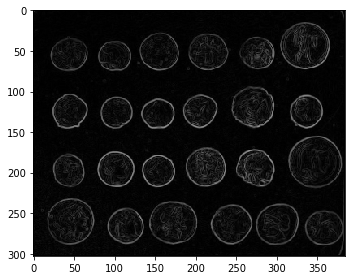

In [0]:
from skimage import data, io, filters

image = data.coins()
edges = filters.sobel(image)
io.imshow(edges)
io.show()

In [0]:
import numpy as np
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from skimage import data
from skimage import color
from skimage.util import view_as_blocks


# get astronaut from skimage.data in grayscale
l = color.rgb2gray(data.astronaut())

# size of blocks
block_shape = (4, 4)

# see astronaut as a matrix of blocks (of shape block_shape)
view = view_as_blocks(l, block_shape)
#See value of  view
view

In [0]:
# collapse the last two dimensions in one
flatten_view = view.reshape(view.shape[0], view.shape[1], -1)

# resampling the image by taking either the `mean`,
# the `max` or the `median` value of each blocks.
mean_view = np.mean(flatten_view, axis=2)
max_view = np.max(flatten_view, axis=2)
median_view = np.median(flatten_view, axis=2)
median_view


array([[6.33314510e-01, 6.48561765e-01, 5.11418039e-01, ...,
        4.81169412e-01, 4.70524706e-01, 4.64768431e-01],
       [8.81597059e-01, 7.98820000e-01, 2.53531373e-01, ...,
        4.74572353e-01, 4.67573922e-01, 4.64497059e-01],
       [8.68704902e-01, 7.80470000e-01, 2.46968431e-01, ...,
        4.76678039e-01, 4.67298627e-01, 4.64928627e-01],
       ...,
       [6.76517451e-01, 7.09151373e-01, 6.14430588e-01, ...,
        7.36501961e-02, 1.44380196e-01, 5.50816667e-01],
       [6.78894902e-01, 6.49334314e-01, 5.24628824e-01, ...,
        1.81757647e-01, 2.48840588e-01, 0.00000000e+00],
       [6.69641569e-01, 5.67081569e-01, 4.90863922e-01, ...,
        1.44212549e-01, 2.17453137e-01, 1.41372549e-04]])

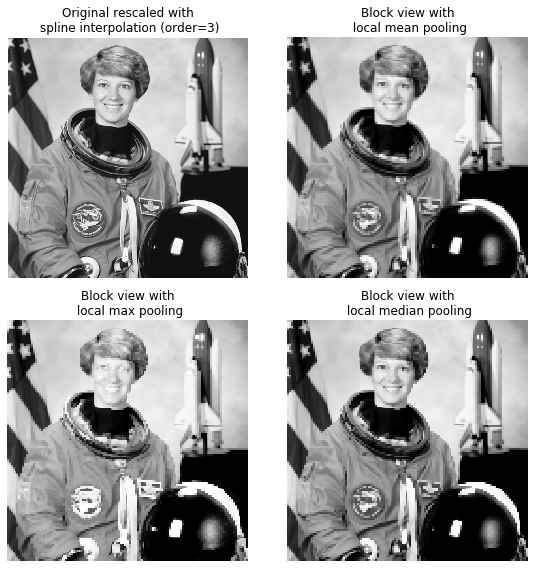

In [0]:

# display resampled images
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

l_resized = ndi.zoom(l, 2, order=3)
ax[0].set_title("Original rescaled with\n spline interpolation (order=3)")
ax[0].imshow(l_resized, extent=(0, 128, 128, 0),
             cmap=cm.Greys_r)

ax[1].set_title("Block view with\n local mean pooling")
ax[1].imshow(mean_view, cmap=cm.Greys_r)

ax[2].set_title("Block view with\n local max pooling")
ax[2].imshow(max_view, cmap=cm.Greys_r)

ax[3].set_title("Block view with\n local median pooling")
ax[3].imshow(median_view, cmap=cm.Greys_r)

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [0]:
# numpy images crash course: https://scikit-image.org/docs/stable/user_guide/numpy_images.html
# more example: https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=hough_line

#Feature Scaling

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing.

Given a data-set with features- Age, Salary, BHK Apartment with the data size of 5000 people, each having these independent data features.
Each data point is labeled as:


    -Class1- YES (means with the given Age, Salary, BHK Apartment feature value one can buy the property)

    -Class2- NO (means with the given Age, Salary, BHK Apartment feature value one can’t buy the property).

Euclidean Distance : It is the square-root of the sum of squares of differences between the coordinates of data point and centroid of each class. This formula is given by Pythagorean theorem.


---

Manhattan Distance : It is calculated as the sum of absolute differences between the coordinates (feature values) of data point and centroid of each class.

![alt text](http://iali.in/img/feature_engg/manh-dis.jpg)


---

Minkowski Distance (Generalization of above methods)

![Equation of Minkowski](http://iali.in/img/feature_engg/mink-dis.jpg)

In [0]:
#Why needed?
# Suppose the centroid of class 1 is [30, 22 Lacs, 3] and data point to be predicted is [47, 33 Lacs, 2].
# using the manhattan method : Distance = (|(30 - 47)| + |(2200000 - 3300000)| + |(3 - 2)|) 
# Do you find something fishy?
#Another ex: 500M > 5KM ?

#Solution:
#Min-Max Normalization or Standardization

#Lets Code Feature Scaling

In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn import preprocessing 
data_set = pd.read_csv('http://iali.in/img/feature_engg/fe.csv') 

In [0]:
data_set.head() 

,Country,Age,Salary,Purchased
0,France,44.0,72000.0,No
1,Spain,27.0,48000.0,Yes
2,Germany,30.0,54000.0,No
3,Spain,38.0,61000.0,No
4,Germany,40.0,NaN,Yes


In [0]:
x = data_set.iloc[:, 1:3].values #A & S [1,2]
print ("\nOriginal data values : \n", x)


Original data values : 
 [[4.4e+01 7.2e+04]
 [2.7e+01 4.8e+04]
 [3.0e+01 5.4e+04]
 [3.8e+01 6.1e+04]
 [4.0e+01     nan]
 [3.5e+01 5.8e+04]
 [    nan 5.2e+04]
 [4.8e+01 7.9e+04]
 [5.0e+01 8.3e+04]
 [3.7e+01 6.7e+04]]


#Mean Max

This technique re-scales a feature or observation value with distribution value between 0 and 1.

In [0]:
from sklearn import preprocessing 
 
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1))  
# Scaled feature 
x_after_min_max_scaler = min_max_scaler.fit_transform(x) 
  
print ("After min max Scaling : \n", x_after_min_max_scaler) 


After min max Scaling : 
 [[0.73913043 0.68571429]
 [0.         0.        ]
 [0.13043478 0.17142857]
 [0.47826087 0.37142857]
 [0.56521739        nan]
 [0.34782609 0.28571429]
 [       nan 0.11428571]
 [0.91304348 0.88571429]
 [1.         1.        ]
 [0.43478261 0.54285714]]


#Standardization: 
It is a very effective technique which re-scales a feature value so that it has distribution with 0 mean value and variance equals to 1.

In [0]:
Standardisation = preprocessing.StandardScaler() 
  
# Scaled feature 
x_after_Standardisation = Standardisation.fit_transform(x) 
  
print ("\nAfter Standardisation : \n", x_after_Standardisation) 


After Standardisation : 
 [[ 0.71993143  0.71101276]
 [-1.62367514 -1.36437583]
 [-1.21009751 -0.84552869]
 [-0.10722383 -0.24020701]
 [ 0.16849459         nan]
 [-0.52080146 -0.49963059]
 [        nan -1.01847774]
 [ 1.27136827  1.31633443]
 [ 1.54708669  1.66223253]
 [-0.24508304  0.27864014]]


## Derived Features

Another useful type of feature is one that is mathematically derived from some input features.
We saw an example of this in  when we constructed *polynomial features* from our input data.
We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input!
This is sometimes known as *basis function regression*, 

For example, this data clearly cannot be well described by a straight line:

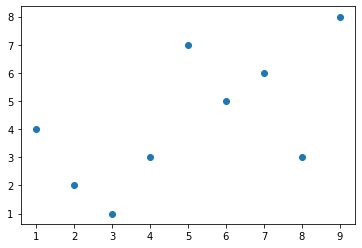

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4,5,6,7,8,9])
y = np.array([4, 2, 1, 3,7, 5,6,3,8])
plt.scatter(x, y);

Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

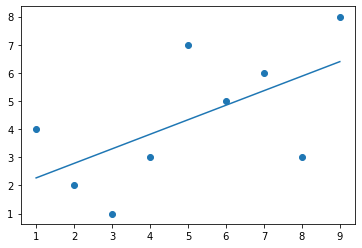

In [0]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model.
For example, we can add polynomial features to the data this way:

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.000e+00 4.000e+00 8.000e+00 1.600e+01]
 [3.000e+00 9.000e+00 2.700e+01 8.100e+01]
 [4.000e+00 1.600e+01 6.400e+01 2.560e+02]
 [5.000e+00 2.500e+01 1.250e+02 6.250e+02]
 [6.000e+00 3.600e+01 2.160e+02 1.296e+03]
 [7.000e+00 4.900e+01 3.430e+02 2.401e+03]
 [8.000e+00 6.400e+01 5.120e+02 4.096e+03]
 [9.000e+00 8.100e+01 7.290e+02 6.561e+03]]


The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$.
Computing a linear regression on this expanded input gives a much closer fit to our data:

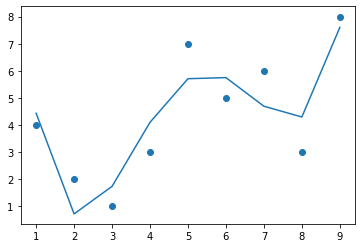

In [0]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit)

This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods.

More generally, this is one motivational path to the powerful set of techniques known as *kernel methods*.

## Imputation of Missing Data

Another common need in feature engineering is handling of missing data.
We discussed the handling of missing data in ``DataFrame``s in, and saw that often the ``NaN`` value is used to mark missing values.
For example, we might have a dataset that looks like this:

In [0]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   nan, 2  ],
              [ 4,   7, nan  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as *imputation* of missing values, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion or a robust model to handle such data).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the ``Imputer`` class:

In [0]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[4.5 , 0.  , 3.  ],
       [3.  , 7.  , 9.  ],
       [3.  , 5.5 , 2.  ],
       [4.  , 7.  , 3.75],
       [8.  , 8.  , 1.  ]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a ``LinearRegression`` estimator:

In [0]:
model = LinearRegression().fit(X2, y)
yfit=model.predict(X2)
yfit

array([13.62181776, 17.25171361,  1.40598148,  3.7587906 , -4.03830345])

In [0]:
df = pd.DataFrame({'Actual': y, 'Predicted': yfit})
df

,Actual,Predicted
0,14,13.621818
1,16,17.251714
2,-1,1.405981
3,8,3.758791
4,-5,-4.038303


## Feature Pipelines

With any of the preceding examples, it can quickly become tedious to do the transformations by hand, especially if you wish to string together multiple steps.
For example, we might want a processing pipeline that looks something like this:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a linear regression

To streamline this type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [0]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


This pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [0]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


# Spiliting data in Train and Test

In [0]:
# Machine Learning  = Training + Testing

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train ,X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3)

In [0]:
X

array([[nan,  0.,  3.],
       [ 3.,  7.,  9.],
       [ 3., nan,  2.],
       [ 4.,  7., nan],
       [ 8.,  8.,  1.]])

In [0]:
X_train

array([[ 3.,  7.,  9.],
       [nan,  0.,  3.],
       [ 3., nan,  2.]])